## Antibody 17C7 Validation Assays

Authored by Arjun Aditham. This notebook produces Figure 3E and supplemental figure S5A. This notebook requires files in the 'RawData' directory.


Required files from 'RawData' directory:
Neut assays were split across 3 plates which are each in separate excel files
- 240726_Plate1_EscapeValidation.xlsx: plate 1 raw RLU data
- 240726_Plate2_EscapeValidation.xlsx: plate 2 raw RLU data
- 240726_Plate3_EscapeValidation.xlsx: plate 3 raw RLU data
- 240726_AntibodyNeutMap.xlsx: antibody map for each plate
- 240726_GenericValidationPlateMap.xlsx: this provides a generic layout for 4 viruses for neut assays on a single plate
- 240726_Virus_Mapping.xlsx: this maps actual mutants to each virus on each plate

In [1]:
import pandas as pd
from matplotlib import pyplot as pl
#import seaborn as sb
import numpy as np
import matplotlib.cm as cm
import scipy.stats
from matplotlib.colors import ListedColormap

In [2]:
#read in excel documents with data


Plate1_data = pd.read_excel('RawData/240726_Plate1_EscapeValidation.xlsx');
Plate1_data['plate_num']=1;

Plate2_data = pd.read_excel('RawData/240726_Plate2_EscapeValidation.xlsx');
Plate2_data['plate_num']=2;

Plate3_data = pd.read_excel('RawData/240726_Plate3_EscapeValidation.xlsx');
Plate3_data['plate_num']=3;


#antibody map

antibody_map = pd.read_excel('RawData/240726_AntibodyNeutMap.xlsx');
antibody_map=antibody_map.rename(columns={"col_coordinate": "Column"})


#plate map

plate_map = pd.read_excel('RawData/240726_GenericValidationPlateMap.xlsx');

#map virus map to mutant
mutant_map = pd.read_excel('RawData/240726_Virus_Mapping.xlsx');

In [3]:
#process plate reader data from raw format

def format_plate_data(plate_df,antibodymap_df,platemap_df,mutant_map):
    #take plate_df and convert well into Row and Column
    plate_copy = plate_df.copy();

    plate_copy['Row']=plate_copy['Well'].apply(lambda x: x[0]);
    plate_copy['Column']=plate_copy['Well'].apply(lambda x: int(x[1:]));

    #okay now merge with plate_map
    plate_copy = pd.merge(plate_copy,plate_map,how='left',on=['Row','Column']);

    #okay let's also merge with the virus map to mutant because I just have V1, etc
    plate_copy = pd.merge(plate_copy,mutant_map,how='left',on=['plate_num','Virus']);

    #okay let's get the background values of the plate. Here, I'll take *all* media wells
    media_only = plate_copy[plate_copy['Virus']=='Media']
    bg = media_only['RLU'].tolist();
    bg_median = np.median(bg);

    #okay let's now noise correct all RLU values
    plate_copy['RLU'] = plate_copy['RLU'].apply(lambda x: x-bg_median);

    #now we need to merge in the antibody map and get concentrations.
    plate_copy = pd.merge(plate_copy,antibody_map,how='left',on=['Column'])

    #okay let's convert the Row values to an ordinal value for dilution factor.
    plate_copy['Dilution_factor']=plate_copy['Row'].apply(lambda x: ord(x)-65);
    plate_copy['antibody_conc']=plate_copy['Antibody_High_Conc']/5**plate_copy['Dilution_factor']

    #okay now we need to calculate the RLU fraction.
    #let me make a minor formatting adjustment where the plate antibody column if 'nan' is actually 'NA'
    plate_copy['Antibody'] = plate_copy['Antibody'].fillna('NA')

    return plate_copy;



In [4]:
Plate1_data_processed = format_plate_data(Plate1_data,antibody_map,plate_map,mutant_map);
Plate2_data_processed = format_plate_data(Plate2_data,antibody_map,plate_map,mutant_map);
Plate3_data_processed = format_plate_data(Plate3_data,antibody_map,plate_map,mutant_map);



def normalize_rlu(group):
    # Get the median of 'RLU' values where 'Antibody' is 'NA'
    median_rlu = group.loc[group['Antibody'] == 'NA', 'RLU'].median()
    
    # Normalize 'RLU' values by dividing by the median
    group['Normalized_RLU'] = group['RLU'] / median_rlu
    return group

# Group by 'Virus' and apply the normalization function
normalized_plate1 = Plate1_data_processed.groupby('Virus').apply(normalize_rlu).reset_index(drop=True)
normalized_plate1 = normalized_plate1[normalized_plate1['Antibody']!='NA'];

normalized_plate2 = Plate2_data_processed.groupby('Virus').apply(normalize_rlu).reset_index(drop=True)
normalized_plate2 = normalized_plate2[normalized_plate2['Antibody']!='NA'];

normalized_plate3 = Plate3_data_processed.groupby('Virus').apply(normalize_rlu).reset_index(drop=True)
normalized_plate3 = normalized_plate3[normalized_plate3['Antibody']!='NA'];





/tmp/ipykernel_62904/406968554.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_plate1 = Plate1_data_processed.groupby('Virus').apply(normalize_rlu).reset_index(drop=True)
/tmp/ipykernel_62904/406968554.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_plate2 = Plate2_data_processed.groupby('Virus').apply(normalize_rlu).reset_index(drop=True)
/tmp/ipykernel_62904/406968554.py:22

In [5]:
#okay maybe we should format some things to make neut-curve compatible.

neutCurve_subset_1=normalized_plate1[['mutant','Antibody','Normalized_RLU','antibody_conc','Column']];
neutCurve_subset_1 = neutCurve_subset_1.rename(columns={'mutant':'virus','Antibody':'serum','Normalized_RLU':'fraction infectivity',
                                                        'Column':'replicate','antibody_conc':'concentration'})
                                                        

neutCurve_subset_2=normalized_plate2[['mutant','Antibody','Normalized_RLU','antibody_conc','Column']];
neutCurve_subset_2 = neutCurve_subset_2.rename(columns={'mutant':'virus','Antibody':'serum','Normalized_RLU':'fraction infectivity',
                                                        'Column':'replicate','antibody_conc':'concentration'})

neutCurve_subset_3=normalized_plate3[['mutant','Antibody','Normalized_RLU','antibody_conc','Column']];
neutCurve_subset_3 = neutCurve_subset_3.rename(columns={'mutant':'virus','Antibody':'serum','Normalized_RLU':'fraction infectivity',
                                                        'Column':'replicate','antibody_conc':'concentration'})


In [6]:
import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

pd.set_option('display.float_format', '{:.3g}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

import os
import yaml

import neutcurve.parse_excel

## The following cells are used to calculate IC50 values and produce Fig S5A

In [7]:
fits = neutcurve.CurveFits(neutCurve_subset_1,fixtop=True)

In [8]:
fits.fitParams(ics=(50,90,99))

/home/aaditham/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/neutcurve/hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,WT,average,2,0.324,interpolated,0.324,5.14,interpolated,5.14,...,interpolated,105,0.324,0.324,interpolated,0.795,1,0,0.976,0.0423
1,17C7,N336S,average,2,1.06,interpolated,1.06,12,interpolated,12,...,interpolated,170,1.06,1.06,interpolated,0.905,1,0,0.975,0.053
2,17C7,I338T,average,2,5e+03,lower,>5e+03,5e+03,lower,>5e+03,...,lower,>5e+03,4.3e+11,5e+03,lower,105,1,0,-1.19,0.212
3,17C7,R333E,average,2,1.09,interpolated,1.09,16.5,interpolated,16.5,...,interpolated,321,1.09,1.09,interpolated,0.808,1,0,0.969,0.0598


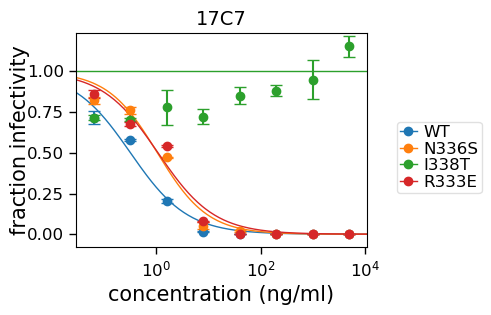

In [9]:
fig, axes = fits.plotSera(xlabel='concentration (ng/ml)',
                          viruses=['WT','N336S','I338T','R333E'],
                          virus_to_color_marker={
                              'WT': ('#1f77b4','o'),
                              'N336S': ('#ff7f0e','o'),
                              'I338T': ('#2ca02c','o'),
                              'R333E': ('#d62728','o')})
#suppressed output
#fig.savefig('240905_Plate1_curves.eps')

In [10]:
fits_2 = neutcurve.CurveFits(neutCurve_subset_2,fixtop=True)
fits_2.fitParams(ics=(50,90,99))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,S341Y,average,2,335,interpolated,335,5e+03,lower,>5e+03,...,lower,>5e+03,335,335,interpolated,0.737,1,0,0.968,0.0587
1,17C7,G343R,average,2,0.625,interpolated,0.625,4.99,interpolated,4.99,...,interpolated,48.2,0.625,0.625,interpolated,1.06,1,0,0.998,0.0161
2,17C7,R346M,average,2,1.14e+03,interpolated,1.14e+03,5e+03,lower,>5e+03,...,lower,>5e+03,1.14e+03,1.14e+03,interpolated,0.905,1,0,0.848,0.129
3,17C7,WT,average,2,0.499,interpolated,0.499,4.54,interpolated,4.54,...,interpolated,50.5,0.499,0.499,interpolated,0.995,1,0,0.985,0.0378


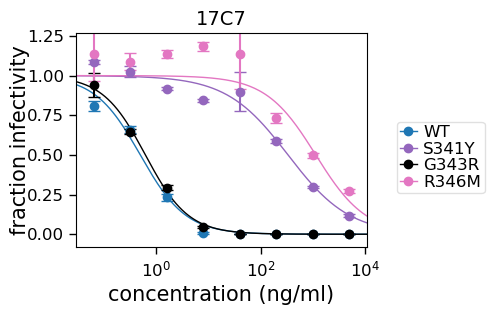

In [11]:
fig, axes = fits_2.plotSera(xlabel='concentration (ng/ml)',
                            viruses=['WT','S341Y','G343R','R346M'],
                            virus_to_color_marker={
                                'WT': ('#1f77b4','o'),
                                'S341Y': ('#9467bd','o'),
                                'G343R': ('k','o'),
                                'R346M': ('#e377c2','o')}
                           )
#suppressed output
#fig.savefig('240905_Plate2_curves.eps')

In [12]:
fits_3 = neutcurve.CurveFits(neutCurve_subset_3,fixtop=True)
fits_3.fitParams(ics=(50,90,99))

/home/aaditham/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/neutcurve/hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,R346E,average,2,1.76e+03,interpolated,1.76e+03,5e+03,lower,>5e+03,...,lower,>5e+03,1.76e+03,1.76e+03,interpolated,0.81,1,0,0.932,0.0632
1,17C7,S341D,average,2,5e+03,lower,>5e+03,5e+03,lower,>5e+03,...,lower,>5e+03,2.15e+11,5e+03,lower,105,1,0,-0.02,0.188
2,17C7,WT,average,2,0.537,interpolated,0.537,3.53,interpolated,3.53,...,interpolated,27.5,0.537,0.537,interpolated,1.17,1,0,0.989,0.0344
3,17C7,L11I,average,2,0.586,interpolated,0.586,6.19,interpolated,6.19,...,interpolated,81.2,0.586,0.586,interpolated,0.932,1,0,0.99,0.0315


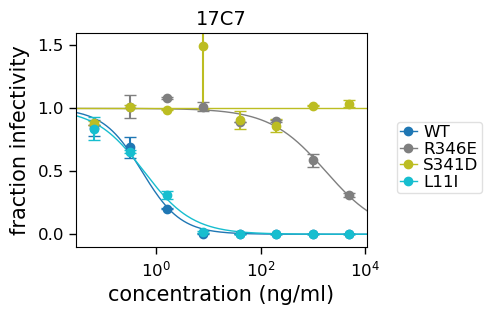

In [13]:
fig, axes = fits_3.plotSera(xlabel='concentration (ng/ml)',
                            viruses=['WT','R346E','S341D','L11I'],
                            virus_to_color_marker={
                                'WT': ('#1f77b4','o'),
                                'R346E': ('#7f7f7f','o'),
                                'S341D': ('#bcbd22','o'),
                                'L11I': ('#17becf','o')}
                           )
#suppressed output
#fig.savefig('240905_Plate3_curves.eps')

In [62]:
#okay now I need to just compute fold-change in IC50s.

# Step 1: Create arrays of data
plate_num_list = mutant_map.plate_num.tolist();
mutant_list = mutant_map.mutant.tolist();
IC50_Numbers = [0.324,1.06,5000,1.09,335,0.625,1140,0.499,1760,5000,0.537,0.586]

# Step 2: Combine arrays into a dictionary (keys will be column names)
data = {
    'plate_num': plate_num_list,
    'mutant': mutant_list,
    'IC50': IC50_Numbers
}

# Step 3: Create DataFrame
df = pd.DataFrame(data)

print(df)


    plate_num mutant     IC50
0           1     WT    0.324
1           1  N336S     1.06
2           1  I338T    5e+03
3           1  R333E     1.09
4           2  S341Y      335
5           2  G343R    0.625
6           2  R346M 1.14e+03
7           2     WT    0.499
8           3  R346E 1.76e+03
9           3  S341D    5e+03
10          3     WT    0.537
11          3   L11I    0.586


In [63]:
#merge data with mutant_map.

merged_IC50 = pd.merge(mutant_map, df, how='left',on=['plate_num','mutant'])

In [64]:
merged_IC50

,plate_num,Virus,mutant,Escape,IC50
0,1,V1,WT,0,0.324
1,1,V2,N336S,1,1.06
2,1,V3,I338T,4.04,5e+03
3,1,V4,R333E,0.4,1.09
4,2,V1,S341Y,2.03,335
5,2,V2,G343R,0.39,0.625
6,2,V3,R346M,2.93,1.14e+03
7,2,V4,WT,0,0.499
8,3,V1,R346E,2.64,1.76e+03
9,3,V2,S341D,3.88,5e+03


In [65]:

def norm_by_wt_plate(group):
    # Get the median of 'RLU' values where 'Antibody' is 'NA'
    WT = group.loc[group['mutant'] == 'WT', 'IC50'].median()
    
    # Normalize 'RLU' values by dividing by the median
    group['IC50_fold_WT'] = group['IC50'] / WT
    return group



merged_IC50_fold_WT = merged_IC50.groupby('plate_num').apply(norm_by_wt_plate).reset_index(drop=True)


/tmp/ipykernel_62904/3272803252.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_IC50_fold_WT = merged_IC50.groupby('plate_num').apply(norm_by_wt_plate).reset_index(drop=True)


In [66]:
merged_IC50_fold_WT

merged_IC50_fold_WT['IC50_mean'] = merged_IC50_fold_WT.groupby('mutant')['IC50'].transform('mean');
merged_IC50_fold_WT['IC50_std'] = merged_IC50_fold_WT.groupby('mutant')['IC50'].transform('std');



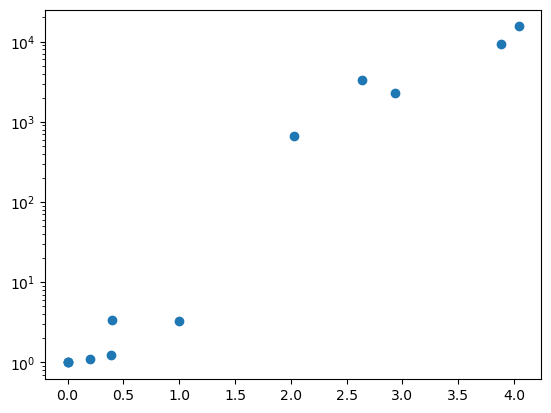

In [67]:
pl.scatter(merged_IC50_fold_WT['Escape'],merged_IC50_fold_WT['IC50_fold_WT']);
pl.yscale('log')

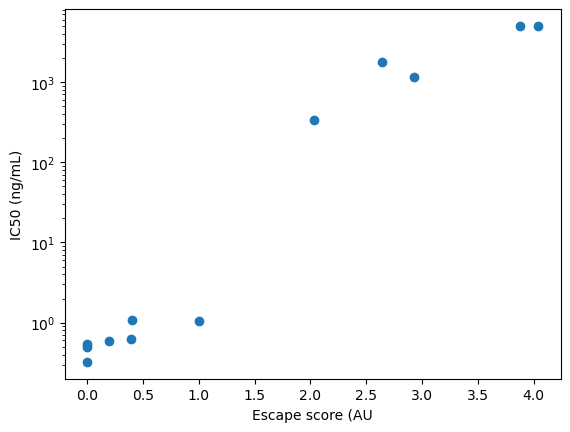

In [68]:
pl.scatter(merged_IC50_fold_WT['Escape'],merged_IC50_fold_WT['IC50']);
pl.ylabel('IC50 (ng/mL)');
pl.xlabel('Escape score (AU');

pl.yscale('log')

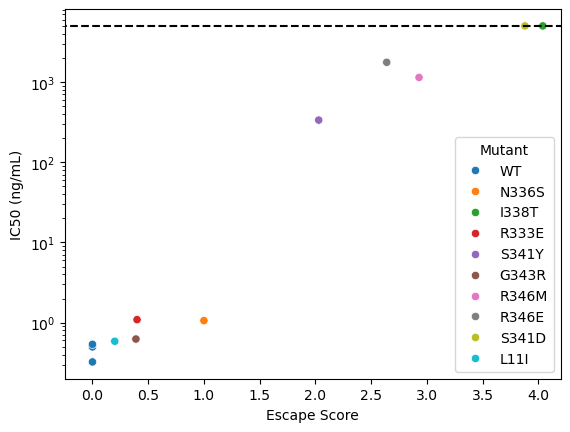

In [69]:
import seaborn as sb

sb.scatterplot(data=merged_IC50_fold_WT, x='Escape', y='IC50', hue='mutant')

# Add a legend
pl.legend(title='Mutant')
pl.yscale('log')

pl.plot([-0.5,4.5],[5000,5000],'k--');
pl.xlim(-0.25,4.2)

pl.ylabel('IC50 (ng/mL)');
pl.xlabel('Escape Score');
# Show the plot
pl.show()

## This cell produces Figure 3E

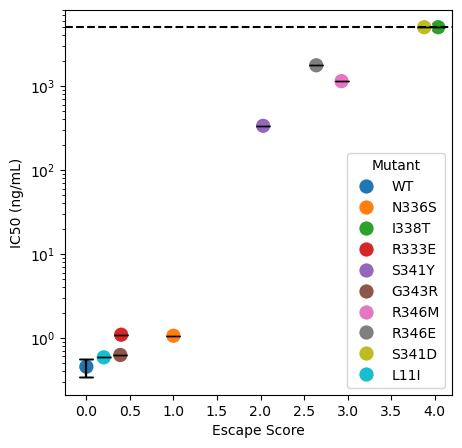

In [70]:


import seaborn as sb


fig, ax = pl.subplots(figsize=(5,5));
sb.scatterplot(data=merged_IC50_fold_WT, x='Escape', y='IC50_mean', hue='mutant',s=125,)


#i want error bars but most of the standard dev will be nan. fill with 0.
merged_IC50_fold_WT['IC50_std']=merged_IC50_fold_WT['IC50_std'].fillna(0);
pl.errorbar(merged_IC50_fold_WT['Escape'], merged_IC50_fold_WT['IC50_mean'], yerr=merged_IC50_fold_WT['IC50_std'], fmt='none', color='k', capsize=5)


pl.plot([-0.5,4.5],[5000,5000],'k--');
pl.xlim(-0.25,4.2)

# Add a legend
pl.legend(title='Mutant')
pl.yscale('log')

pl.ylabel('IC50 (ng/mL)');
pl.xlabel('Escape Score');
# Show the plot
pl.show()

#suppressed output
#fig.savefig('240905_IC50_raw.eps');

In [71]:
#I'm dropping duplicates of the WT virus so that they are not over-counted in the regression.

merged_IC50_fold_WT_dropWT_Duplicates = merged_IC50_fold_WT.drop_duplicates(subset=['mutant']);



In [73]:
from scipy.stats import linregress

#last-minute log-transform for linear regression since we log-transformed the plot. 

merged_IC50_fold_WT_dropWT_Duplicates['log_IC50_mean']=merged_IC50_fold_WT_dropWT_Duplicates['IC50_mean'].apply(lambda x: np.log10(x))
slope, intercept, r_value, p_value, std_err = linregress(merged_IC50_fold_WT_dropWT_Duplicates['Escape'], merged_IC50_fold_WT_dropWT_Duplicates['log_IC50_mean'])


/tmp/ipykernel_62904/399423177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_IC50_fold_WT_dropWT_Duplicates['log_IC50_mean']=merged_IC50_fold_WT_dropWT_Duplicates['IC50_mean'].apply(lambda x: np.log10(x))


In [75]:
r_value

0.9708357597479135

In [76]:
#look at df for the transformation. makes sense std is 0 for most. 
merged_IC50_fold_WT_dropWT_Duplicates

,plate_num,Virus,mutant,Escape,IC50,IC50_fold_WT,IC50_mean,IC50_std,log_IC50_mean
0,1,V1,WT,0,0.324,1,0.453,0.114,-0.344
1,1,V2,N336S,1,1.06,3.27,1.06,0,0.0253
2,1,V3,I338T,4.04,5e+03,1.54e+04,5e+03,0,3.7
3,1,V4,R333E,0.4,1.09,3.36,1.09,0,0.0374
4,2,V1,S341Y,2.03,335,671,335,0,2.53
5,2,V2,G343R,0.39,0.625,1.25,0.625,0,-0.204
6,2,V3,R346M,2.93,1.14e+03,2.28e+03,1.14e+03,0,3.06
8,3,V1,R346E,2.64,1.76e+03,3.28e+03,1.76e+03,0,3.25
9,3,V2,S341D,3.88,5e+03,9.31e+03,5e+03,0,3.7
11,3,V4,L11I,0.2,0.586,1.09,0.586,0,-0.232
